MIT License

Copyright (c) Microsoft Corporation. All rights reserved.

This notebook is adapted from Francesca Lazzeri Energy Demand Forecast Workbench workshop.

Copyright (c) 2021 PyLadies Amsterdam, Alyona Galyeva

# Ridge regression

In [1]:
%matplotlib inline
import os
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from azureml.core import Workspace, Dataset
from azureml.core.experiment import Experiment
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
WORKDIR = os.getcwd()
MODEL_NAME = "ridge"

In [3]:
ws = Workspace.from_config()

In [4]:
#Obtain the data from the cloud storage
train_ds = Dataset.get_by_name(ws, name="train_nyc_demand_data")
print(train_ds.name, train_ds.version)

train_nyc_demand_data 1


In [5]:
train = train_ds.to_pandas_dataframe()
train.head()

,timeStamp,demand,precip,temp,hour,month,dayofweek,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
0,2012-01-01 06:00:00,4324.9,0.0,38.78,6,0,6,39.02,42.61,45.03,45.04,45.89,46.13,4274.7,4275.5,4357.7,4542.6,4752.1,4937.5
1,2012-01-01 07:00:00,4350.0,0.0,42.74,7,0,6,38.78,39.02,42.61,45.03,45.04,45.89,4324.9,4274.7,4275.5,4357.7,4542.6,4752.1
2,2012-01-01 08:00:00,4480.9,0.0,38.90,8,0,6,42.74,38.78,39.02,42.61,45.03,45.04,4350.0,4324.9,4274.7,4275.5,4357.7,4542.6
3,2012-01-01 09:00:00,4664.2,0.0,44.67,9,0,6,38.90,42.74,38.78,39.02,42.61,45.03,4480.9,4350.0,4324.9,4274.7,4275.5,4357.7
4,2012-01-01 10:00:00,4847.5,0.0,47.43,10,0,6,44.67,38.90,42.74,38.78,39.02,42.61,4664.2,4480.9,4350.0,4324.9,4274.7,4275.5


Create model pipeline:
- **one-hot encode categorical variables**
- **randomized parameter search** with cross validation to find optimal values for the alpha parameter

Fitting this pipeline should take less than a minute.

In [6]:
# Drop the target and the timeStamp
X = train.drop(['demand', 'timeStamp'], axis=1)

In [7]:
# Creates the new experiment for the new model
ridge_experiment = Experiment(ws, name="Ridge")
run = ridge_experiment.start_logging()

run.log("dataset name", train_ds.name)
run.log("dataset version", train_ds.version)

In [8]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
run.log_list("cat_cols", cat_cols)
preprocessor = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), cat_cols_idx)], remainder='passthrough')
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [9]:
param_dist = {'alpha': st.uniform(1e-4, 10.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=100,
                            scoring='neg_mean_squared_error',
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('preprocessor', preprocessor), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])
run.log("pipeline steps", regr_pipe.named_steps)
run.log_list("param_dist", param_dist)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [10]:
# store the new model in the cloud
with open(os.path.join(WORKDIR, MODEL_NAME + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [11]:
# Cross validation with model from the cloud
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
run.log_list("cv_results", regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
40,0.045767,0.004277,0.003826,0.001091,6.28452,{'alpha': 6.284520196860089},-4167.596110,-3679.051292,-3789.921261,-3878.856221,209.126883,1
71,0.015475,0.002015,0.001674,0.000141,6.370927,{'alpha': 6.370926653549964},-4167.731118,-3678.999282,-3789.839251,-3878.856550,209.217210,2
9,0.027280,0.010014,0.001830,0.000399,6.4008,{'alpha': 6.400800064661093},-4167.778345,-3678.981501,-3789.811042,-3878.856963,209.248609,3
80,0.041896,0.011344,0.001721,0.000268,6.188027,{'alpha': 6.188026678226168},-4167.448169,-3679.110399,-3790.013584,-3878.857384,209.026888,4
13,0.029313,0.011705,0.001632,0.000157,6.163453,{'alpha': 6.163453258217401},-4167.410975,-3679.125625,-3790.037221,-3878.857941,209.001572,5


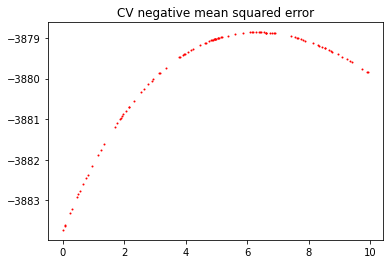

In [12]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
run.log_image("CV errors plot", plot=plt)
plt.show()

In [13]:
run.complete()